<a href="https://colab.research.google.com/github/RoseJaisil/Segmentation-Algorithms/blob/main/UNet_for__Nuclei_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py



In [ ]:
from google.colab import files
files.upload()

Saving stage2_test_final.zip to stage2_test_final.zip


In [ ]:
!unzip stage1_test.zip -d stage1_test

In [ ]:
!unzip stage1_train.zip -d stage1_train

Import libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm # it shows the progress
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from matplotlib import pyplot as plt

In [ ]:
seed = 42
np.random.seed = seed

Importing the data and resizing to fit the network

In [ ]:

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1] # next helps in iteration
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print('Resizing the images....')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_
  img = imread(path+ '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  for mask_file in next(os.walk(path + '/masks'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

  y_train[n] = mask
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH + id_
  img = imread(path+ '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = img

print('Done with Resizing')



<ipython-input-15-1704a7e107ec>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
<ipython-input-15-1704a7e107ec>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


Resizing the images....


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-15-1704a7e107ec>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 65/65 [00:01<00:00, 36.64it/s]

Done with Resizing


Building the model

In [ ]:
#Building the model - Note: Always verify the model architecture

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs) # converting the pixel values from 8 bit to floating values

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(s) # kernel_initialization - defines the initial values
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c1) # kernel_initialization - defines the initial values
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(p1) # kernel_initialization - defines the initial values
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c2) # kernel_initialization - defines the initial values
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(p2) # kernel_initialization - defines the initial values
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c3) # kernel_initialization - defines the initial values
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(p3) # kernel_initialization - defines the initial values
c4 = tf.keras.layers.Dropout(0.3)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c4) # kernel_initialization - defines the initial values
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(p4) # kernel_initialization - defines the initial values
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c5) # kernel_initialization - defines the initial values

# Expansion path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(u6) # kernel_initialization - defines the initial values
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c6) # kernel_initialization - defines the initial values

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(u7) # kernel_initialization - defines the initial values
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c7) # kernel_initialization - defines the initial values

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(u8) # kernel_initialization - defines the initial values
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c8) # kernel_initialization - defines the initial values

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(u9) # kernel_initialization - defines the initial values
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c9) # kernel_initialization - defines the initial values

outputs = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Training

In [ ]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_for_nuclei.h5", verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X_train,y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 157s 4s/step - loss: 0.6176 - accuracy: 0.7497 - val_loss: 0.5181 - val_accuracy: 0.7323
Epoch 2/25
38/38 [==============================] - 145s 4s/step - loss: 0.3511 - accuracy: 0.8228 - val_loss: 0.2105 - val_accuracy: 0.9284
Epoch 3/25
38/38 [==============================] - 148s 4s/step - loss: 0.1999 - accuracy: 0.9266 - val_loss: 0.1316 - val_accuracy: 0.9481
Epoch 4/25
38/38 [==============================] - 144s 4s/step - loss: 0.1489 - accuracy: 0.9406 - val_loss: 0.1093 - val_accuracy: 0.9549
Epoch 5/25
38/38 [==============================] - 150s 4s/step - loss: 0.1395 - accuracy: 0.9451 - val_loss: 0.1075 - val_accuracy: 0.9566
Epoch 6/25
38/38 [==============================] - 142s 4s/step - loss: 0.1265 - accuracy: 0.9501 - val_loss: 0.1028 - val_accuracy: 0.9564
Epoch 7/25
38/38 [==============================] - 145s 4s/step - loss: 0.1170 - accuracy: 0.9539 - val_loss: 0.0983 - val_accuracy: 0.9606
Epoch 8/25
38

In [ ]:
model.save("my_first_trained_UNet_model.h5")

In [ ]:
idx = random.randint(0 , len(X_train))

# predictions where each pixel is interms of probability (btw 0 and 1)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) # 90 % of the training data
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) # remaining 10% of the training data
preds_test = model.predict(X_test, verbose=1) # prediction on the testing dataset

# converting the probability to 0's and 1's
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



3/3 [==============================] - 3s 784ms/step


Perform sanity check on a randon training samples

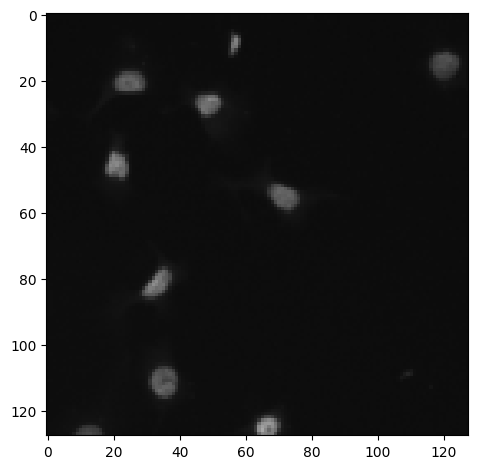

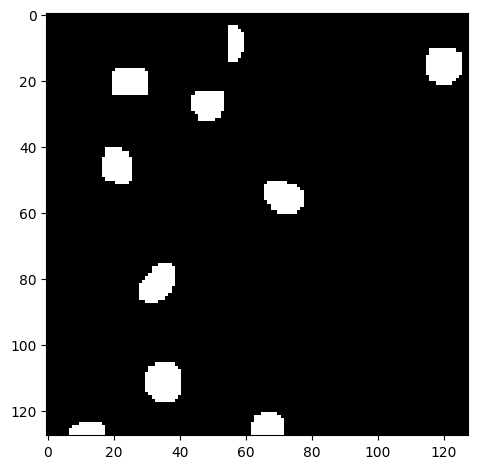

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


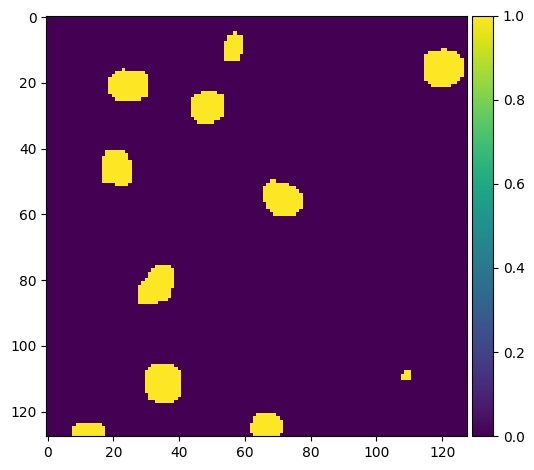

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])

plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

Perform sanity check on a randon validation samples

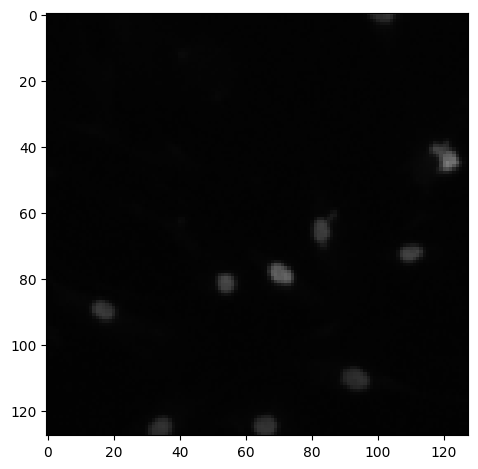

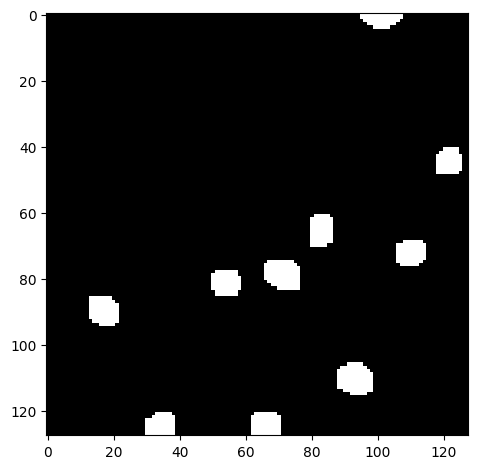

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


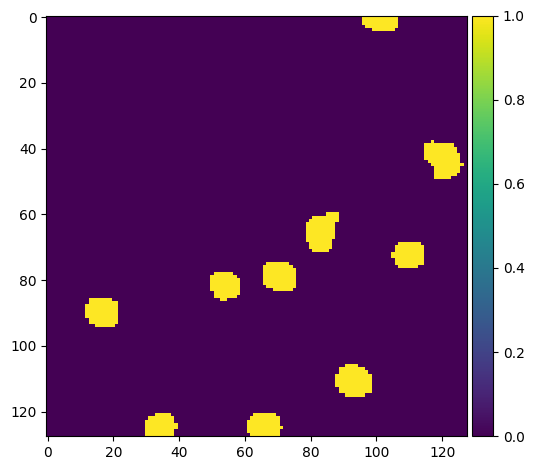

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):])[ix])
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Reference: @author: Sreenivas Bhattiprolu
https://github.com/bnsreenu